In [ ]:
import networkx as nx
import numpy as np
import os
import time
import pandas as pd
import matplotlib.pyplot as plt
from itertools import chain
from collections import defaultdict
from gensim.models import Word2Vec
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score

# Pipeline

### Data Loader

We need to load networks into memory. Usually networks are organized as pairs of nodes. And sometimes different edges have different weights. Hence, we use networkx.DiGraph to store such structure information and attributes.

In [ ]:
def load_data(file_name):
    """
    read edges from an edge file
    """
    edges = list()
    df = pd.read_csv(file_name)
    for idx, row in df.iterrows():
        user_id, friends = row["user_id"], eval(row["friends"])
        for friend in friends:
            # add each friend relation as an edge
            edges.append((user_id, friend))
    edges = sorted(edges)
    
    return edges

def load_test_data(file_name):
    """
    read edges from an edge file
    """
    edges = list()
    scores = list()
    df = pd.read_csv(file_name)
    for idx, row in df.iterrows():
        edges.append((row["src"], row["dst"]))
    edges = sorted(edges)
    
    return edges

def generate_false_edges(true_edges, num_false_edges=5):
    """
    generate false edges given true edges
    """
    nodes = list(set(chain.from_iterable(true_edges)))
    N = len(nodes)
    true_edges = set(true_edges)
    print(N, len(true_edges))
    false_edges = set()
    
    while len(false_edges) < num_false_edges:
        # randomly sample two different nodes and check whether the pair exisit or not
        src, dst = nodes[int(np.random.rand() * N)], nodes[int(np.random.rand() * N)]
        if src != dst and (src, dst) not in true_edges and (src, dst) not in false_edges:
            false_edges.add((src, dst))
    false_edges = sorted(false_edges)
    
    return false_edges

def construct_graph_from_edges(edges):
    """
    generate a directed graph object given true edges
    DiGraph documentation: https://networkx.github.io/documentation/stable/reference/classes/digraph.html
    """
    # convert a list of edges {(u, v)} to a list of edges with weights {(u, v, w)}
    edge_weight = defaultdict(float)
    for e in edges:
        edge_weight[e] += 1.0
    weighed_edge_list = list()
    for e in sorted(edge_weight.keys()):
        weighed_edge_list.append((e[0], e[1], edge_weight[e]))
        
    graph = nx.DiGraph()
    graph.add_weighted_edges_from(weighed_edge_list)
    
    print("number of nodes:", graph.number_of_nodes())
    print("number of edges:", graph.number_of_edges())
    
    return graph

### Random Walk Generator

Random walk generators or random walkers yield random walks that contain both local and higher-order neighborhood information. However, naive non-uniform sampling is very slow, which requires O(n) time complexity. Here alias sampling can reduce the time complexity to O(1) with O(n) space. If you are interested, please see the following blog.

In [ ]:
def alias_setup(probs):
    """
    compute utility lists for non-uniform sampling from discrete distributions.
    details: https://lips.cs.princeton.edu/the-alias-method-efficient-sampling-with-many-discrete-outcomes/
    """
    K = len(probs)
    q = np.zeros(K)
    J = np.zeros(K, dtype=int)  # replaced np.int with int to remove warning

    smaller = list()
    larger = list()
    for kk, prob in enumerate(probs):
        q[kk] = K * prob
        if q[kk] < 1.0:
            smaller.append(kk)
        else:
            larger.append(kk)

    while len(smaller) > 0 and len(larger) > 0:
        small = smaller.pop()
        large = larger.pop()

        J[small] = large
        q[large] = q[large] + q[small] - 1.0
        if q[large] < 1.0:
            smaller.append(large)
        else:
            larger.append(large)

    return J, q

def get_alias_node(graph, node):
    """
    get the alias node setup lists for a given node.
    """
    # get the unnormalized probabilities with the first-order information
    unnormalized_probs = list()
    for nbr in graph.neighbors(node):
        unnormalized_probs.append(graph[node][nbr]["weight"])
    unnormalized_probs = np.array(unnormalized_probs)
    if len(unnormalized_probs) > 0:
        normalized_probs = unnormalized_probs / unnormalized_probs.sum()
    else:
        normalized_probs = unnormalized_probs
        
    return alias_setup(normalized_probs)
    
def get_alias_edge(graph, src, dst, p=1, q=1):
    """
    get the alias edge setup lists for a given edge.
    """
    # get the unnormalized probabilities with the second-order information
    unnormalized_probs = list()
    for dst_nbr in graph.neighbors(dst):
        if dst_nbr == src: # distance is 0
            unnormalized_probs.append(graph[dst][dst_nbr]["weight"]/p)
        elif graph.has_edge(dst_nbr, src): # distance is 1
            unnormalized_probs.append(graph[dst][dst_nbr]["weight"])
        else: # distance is 2
            unnormalized_probs.append(graph[dst][dst_nbr]["weight"]/q)
    unnormalized_probs = np.array(unnormalized_probs)
    if len(unnormalized_probs) > 0:
        normalized_probs = unnormalized_probs / unnormalized_probs.sum()
    else:
        normalized_probs = unnormalized_probs

    return alias_setup(normalized_probs)

def preprocess_transition_probs(graph, p=1, q=1):
    """
    preprocess transition probabilities for guiding the random walks.
    """
    alias_nodes = dict()
    for node in graph.nodes():
        alias_nodes[node] = get_alias_node(graph, node)

    alias_edges = dict()
    for edge in graph.edges():
        alias_edges[edge] = get_alias_edge(graph, edge[0], edge[1], p=p, q=q)

    return alias_nodes, alias_edges

The difference between DeepWalk and node2vec is how to generate random walks. The former only consider the first-order information while the latter also involves the second-order information.

In [ ]:
def alias_draw(J, q):
    """
    draw sample from a non-uniform discrete distribution using alias sampling.
    """
    K = len(J)

    kk = int(np.floor(np.random.rand() * K))
    if np.random.rand() < q[kk]:
        return kk
    else:
        return J[kk]


# helper function to generate the long random walk as desired
def fallback(walk, fetch_last_num=1):
    if len(walk) > fetch_last_num:
        walk.pop()
        fetched = []
        for i in range(fetch_last_num):
            fetched.append(walk[-1-i])
        return walk, fetched
    else:
        return [], [None for _ in range(fetch_last_num)]

def generate_first_order_random_walk(graph, alias_nodes, 
                                     walk_length=10, start_node=None, verbose=False, max_trails=10):
    """
    simulate a random walk starting from start node and considering the first order information.
    max_trials: set the max trials to be one for standard random walk. Larger max_trails will make the generated biased.
    """
    if start_node == None:
        start_node = np.random.choice(graph.nodes())
    walk = [start_node]
    cur = start_node
    num_tried = 0
    
    ########## begin ##########
    while len(walk) < walk_length:
        cur_nbrs = list(graph.neighbors(cur))
        if len(cur_nbrs) > 0: # if we can sample next nodes
            # sample the next node based on alias_nodes
            cur = cur_nbrs[alias_draw(*alias_nodes[cur])]
            walk.append(cur)
        else: # if we can't do that
            num_tried += 1
            if num_tried >= max_trails:
                break

            walk, fetched = fallback(walk, fetch_last_num=1)
            cur = fetched[0]
            if len(walk) == 0: # if falls back to the empty walk
                start_node = np.random.choice(graph.nodes())
                walk = [start_node]
                cur = start_node
    ########## end ##########

    if verbose: 
        print(f'walk of lenght {len(walk)} generated with {num_tried} trails')
    return walk
    
def generate_second_order_random_walk(graph, alias_nodes, alias_edges, 
                                      walk_length=10, start_node=None, verbose=False, max_trails=10):
    """
    simulate a random walk starting from start node and considering the second order information.
    """
    if start_node == None:
        start_node = np.random.choice(graph.nodes())
    walk = [start_node]
    
    prev = None
    cur = start_node
    num_tried = 0

    ########## begin ##########
    while len(walk) < walk_length:
        cur_nbrs = list(graph.neighbors(cur))
        if len(cur_nbrs) > 0:
            if prev is None:
                # sample the next node based on alias_nodes
                prev, cur = cur, cur_nbrs[alias_draw(*alias_nodes[cur])]
            else:
                # sample the next node based on alias_edges
                prev, cur = cur, cur_nbrs[alias_draw(*alias_edges[(prev, cur)])]
            walk.append(cur)
        else:
            num_tried += 1
            if num_tried >= max_trails:
                break
            walk, (cur, prev) = fallback(walk, fetch_last_num=2)
            if len(walk) == 0:
                start_node = np.random.choice(graph.nodes())
                walk = [start_node]
                cur = start_node
                prev = None
    ########## end ##########
    if verbose: 
        print(f'walk of lenght {len(walk)} generated with {num_tried} trails')
    return walk

### Network Embedding Algorithms

In [ ]:
def build_deepwalk(graph, alias_nodes, node_dim=10, num_walks=10, walk_length=10, window_size=3):  # added window_size parameter by HCJ
    """
    build a deepwalk model
    """
    print("building a DeepWalk model...", end="\t")
    st = time.time()
    np.random.seed(0)
    nodes = list(graph.nodes())
    walks = list()
    # generate random walks
    for walk_iter in range(num_walks):
        np.random.shuffle(nodes)
        for node in nodes:
            walks.append(generate_first_order_random_walk(
                graph, alias_nodes, walk_length=walk_length, start_node=node))
        
    walk_lens = [len(w) for w in walks]
    if len(walk_lens) > 0:
        avg_walk_len = sum(walk_lens) / len(walk_lens)
    else:
        avg_walk_len = 0.0
    print("number of walks: %d\taverage walk length: %.4f" % (len(walks), avg_walk_len), end="\t")
    
    # train a skip-gram model for these walks
    # changed from vector_size=node_dim to size=node_dim and epochs=10 to iter=10 by HCJ
    model = Word2Vec(walks, size=node_dim, window=window_size, min_count=0, sg=1, workers=os.cpu_count(), iter=10)
    print("training time: %.4f" % (time.time()-st))
    
    return model

def build_node2vec(graph, alias_nodes, alias_edges, node_dim=10, num_walks=10, walk_length=10, window_size=3):  # added window size parameter by HCJ
    """
    build a node2vec model
    """
    print("building a node2vec model...", end="\t")
    st = time.time()
    np.random.seed(0)
    nodes = list(graph.nodes())
    walks = list()
    # generate random walks
    for walk_iter in range(num_walks):
        np.random.shuffle(nodes)
        for node in nodes:
            walks.append(generate_second_order_random_walk(
                graph, alias_nodes, alias_edges, walk_length=walk_length, start_node=node))
            
    walk_lens = [len(w) for w in walks]
    if len(walk_lens) > 0:
        avg_walk_len = sum(walk_lens) / len(walk_lens)
    else:
        avg_walk_len = 0.0    
    print("number of walks: %d\taverage walk length: %.4f" % (len(walks), avg_walk_len), end="\t")
    
    # train a skip-gram model for these walks
    # changed from vector_size=node_dim to size=node_dim and epochs=10 to iter=10 by HCJ
    model = Word2Vec(walks, size=node_dim, window=window_size, min_count=0, sg=1, workers=os.cpu_count(), iter=10)
    print("training time: %.4f" % (time.time()-st))
    
    return model

### Scorer

In [ ]:
def get_cosine_sim(model, u, v):
    """
    get the cosine similarity between two nodes
    """
    try:
        u = model.wv[u]
        v = model.wv[v]
        return np.dot(u, v) / (np.linalg.norm(u) * np.linalg.norm(v))
    except:
        return 0.5

def get_auc_score(model, true_edges, false_edges):
    """
    get the auc score
    """
    y_true = [1] * len(true_edges) + [0] * len(false_edges)
    
    y_score = list()
    for e in true_edges:
        y_score.append(get_cosine_sim(model, e[0], e[1]))
    for e in false_edges:
        y_score.append(get_cosine_sim(model, e[0], e[1]))
    
    return roc_auc_score(y_true, y_score)

def write_pred(file_name, edges, scores):
    df = pd.DataFrame()
    df["src"] = [e[0] for e in edges]
    df["dst"] = [e[1] for e in edges]
    df["score"] = scores
    df.to_csv(file_name, index=False)

def write_valid_ans(file_name, edges, scores):
    df = pd.DataFrame()
    df["src"] = [e[0] for e in edges]
    df["dst"] = [e[1] for e in edges]
    df["score"] = scores
    df.to_csv(file_name, index=False)

### Try them over a Real-life Network

Firstly, we need to load edges into memory and use the networkx.DiGraph structure to store the graph.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# load the appropriate directory on Google Drive
!rm -f data
%cd /content/drive/My Drive/4-2/COMP4332/Project2/data

train_file = "./train.csv"
valid_file = "./valid.csv"
test_file = "./test.csv"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/4-2/COMP4332/Project2/data


In [ ]:
np.random.seed(0)
train_edges = load_data(train_file)
graph = construct_graph_from_edges(train_edges)
valid_edges = load_data(valid_file)
# train_edges and valid_edges are distinct. Since there are 19267 validation edges, generate 40000-19267=20733 false edges. We want the amount of false edges to be roughly equal to true edges for class balance.
false_edges = generate_false_edges(train_edges+valid_edges, 40000-len(valid_edges))
test_edges = load_test_data(test_file)

number of nodes: 8343
number of edges: 100000
8496 119267


After that, we can use preprocess transition probabilities with the help of alias sampling.

In [ ]:
alias_nodes, alias_edges = preprocess_transition_probs(graph, p=1, q=1)

We can use random walk generators to generate random walks.

Let's try to generate a first-order random walk and a second-order random walk.

In [ ]:
generate_first_order_random_walk(graph, alias_nodes=alias_nodes,
                                 start_node="N6ZTMIue-2b30CJv2tyPGg", walk_length=10)

['N6ZTMIue-2b30CJv2tyPGg',
 'wAqiSluTMo_2T-dTN4Bozg',
 '4FXbovgSEFZ5_9S5wddFIg',
 'UCePaJxpQcMSK0fgE9hMuA',
 '4FXbovgSEFZ5_9S5wddFIg',
 'T8LqkYbwMPZmvXSsUfN8sQ',
 'rzq5nqG2NG13o3ISxJSrsQ',
 'PeLGa5vUR8_mcsn-fn42Jg',
 'rzq5nqG2NG13o3ISxJSrsQ',
 'w1TjcJ6itK7LC_IY61NQIQ']

In [ ]:
generate_second_order_random_walk(graph, alias_nodes=alias_nodes, alias_edges=alias_edges,
                                  start_node="N6ZTMIue-2b30CJv2tyPGg", walk_length=10)

['N6ZTMIue-2b30CJv2tyPGg',
 'aKhv49qQ1A1MDvGZ-cVh7Q',
 'kCVPl2RumlSgSDx9PMfXDA',
 '04J_q_VhSBItxNiEAN-gkA',
 '82dCHyU-ANOgdhxUgZsUeg',
 'Ar3bat-NGasrXDiS7WF8OA',
 '4qmjySJprpPSKDoxHLIuEQ',
 'Ar3bat-NGasrXDiS7WF8OA',
 'pQ6jXAENt9gUHqQvXl4DTg',
 'Ar3bat-NGasrXDiS7WF8OA']

And we can build a DeepWalk model just to test out the embeddings.

In [ ]:
model = build_deepwalk(graph, alias_nodes, node_dim=10, num_walks=5, walk_length=5)

building a DeepWalk model...	number of walks: 41715	average walk length: 4.9594	training time: 13.3569


Let's see the node embeddings of three nodes, and cosine similarities of two edges.

In [ ]:
print("node embedding (\"N6ZTMIue-2b30CJv2tyPGg\"):",
      model.wv["N6ZTMIue-2b30CJv2tyPGg"])
print("node embedding (\"N7E-CfqdME28dakWdEKNvw\"):",
      model.wv["N7E-CfqdME28dakWdEKNvw"])
# unused, not necessary
unused = """
print("node embedding (\"MmlJSLDg-IFaeXb5wdJbgg\"):",
      model.wv.vectors[model.wv.index_to_key.index("MmlJSLDg-IFaeXb5wdJbgg")])
print("true edge (\"N6ZTMIue-2b30CJv2tyPGg\", \"N7E-CfqdME28dakWdEKNvw\"):",
      get_cosine_sim(model, "N6ZTMIue-2b30CJv2tyPGg", "N7E-CfqdME28dakWdEKNvw"))
print("false edge (\"N6ZTMIue-2b30CJv2tyPGg\", \"MmlJSLDg-IFaeXb5wdJbgg\"):",
      get_cosine_sim(model, "N6ZTMIue-2b30CJv2tyPGg", "MmlJSLDg-IFaeXb5wdJbgg"))
"""

node embedding ("N6ZTMIue-2b30CJv2tyPGg"): [-0.72891504  0.35915303  2.0209687  -0.01987291 -0.78035325 -0.15174383
 -0.5923883   0.67961794 -1.1858759  -0.63306725]
node embedding ("N7E-CfqdME28dakWdEKNvw"): [ 0.05572268  0.29713395  2.3199825   0.44634232 -0.7893717   0.22651036
 -0.38588277  1.0432173  -1.3756577  -0.7393767 ]


# Link Prediction

We can train the model with different parameters and test the model on the validation set. Please show your parameter search process and analysis in your code, and visualization tools (Heatmap, etc.) are recommended to make your analysis clear.

In [ ]:
np.random.seed(0)

node_dim = 10
num_walks_list = [5, 10, 15, 20]
walk_length_list = [10, 15, 20, 30]
windowsize_list = [3, 5, 10]

deepwalk_auc_scores = dict()
for num_walks in num_walks_list:
    for walk_length in walk_length_list:
        for wsize in windowsize_list:
            print("node dim: %d,\tnum_walks: %d,\twalk_length: %d\twindow_size: %d" % (node_dim, num_walks, walk_length, wsize), end="\t")
            model = build_deepwalk(graph, alias_nodes, 
                          node_dim=node_dim, num_walks=num_walks, walk_length=walk_length, window_size=wsize)
            deepwalk_auc_scores[(node_dim, num_walks, walk_length, wsize)] = get_auc_score(model, valid_edges, false_edges)
            print("auc: %.4f" % (deepwalk_auc_scores[(node_dim, num_walks, walk_length, wsize)]))

node dim: 10,	num_walks: 5,	walk_length: 10	window_size: 3	building a DeepWalk model...	number of walks: 41715	average walk length: 9.8900	training time: 20.6311
auc: 0.9116
node dim: 10,	num_walks: 5,	walk_length: 10	window_size: 5	building a DeepWalk model...	number of walks: 41715	average walk length: 9.8900	training time: 24.2659
auc: 0.9215
node dim: 10,	num_walks: 5,	walk_length: 10	window_size: 10	building a DeepWalk model...	number of walks: 41715	average walk length: 9.8900	training time: 28.5752
auc: 0.9268
node dim: 10,	num_walks: 5,	walk_length: 15	window_size: 3	building a DeepWalk model...	number of walks: 41715	average walk length: 14.8131	training time: 27.3198
auc: 0.9227
node dim: 10,	num_walks: 5,	walk_length: 15	window_size: 5	building a DeepWalk model...	number of walks: 41715	average walk length: 14.8131	training time: 33.1211
auc: 0.9291
node dim: 10,	num_walks: 5,	walk_length: 15	window_size: 10	building a DeepWalk model...	number of walks: 41715	average walk le

Example of using Heatmap to viualize the result for each value of window_size.

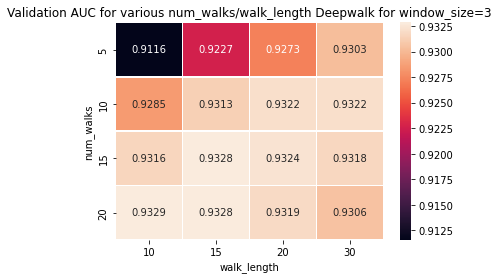

In [ ]:
import seaborn as sns

node_dim = 10
deepwalk_auc_as_np = np.array([[deepwalk_auc_scores[(node_dim, num_walks, walk_length, 3)] for walk_length in walk_length_list] for num_walks in num_walks_list])

ax_deepwalk = sns.heatmap(deepwalk_auc_as_np, annot=True, fmt='.4g', linewidth=0.5, 
                            xticklabels=walk_length_list, yticklabels=num_walks_list)
ax_deepwalk.set_xlabel('walk_length', fontsize=10)
ax_deepwalk.set_ylabel('num_walks', fontsize=10)
ax_deepwalk.set_title("Validation AUC for various num_walks/walk_length Deepwalk for window_size=3")
plt.show()

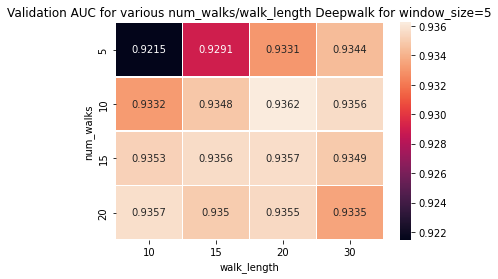

In [ ]:
deepwalk_auc_as_np = np.array([[deepwalk_auc_scores[(node_dim, num_walks, walk_length, 5)] for walk_length in walk_length_list] for num_walks in num_walks_list])

ax_deepwalk = sns.heatmap(deepwalk_auc_as_np, annot=True, fmt='.4g', linewidth=0.5, 
                            xticklabels=walk_length_list, yticklabels=num_walks_list)
ax_deepwalk.set_xlabel('walk_length', fontsize=10)
ax_deepwalk.set_ylabel('num_walks', fontsize=10)
ax_deepwalk.set_title("Validation AUC for various num_walks/walk_length Deepwalk for window_size=5")
plt.show()

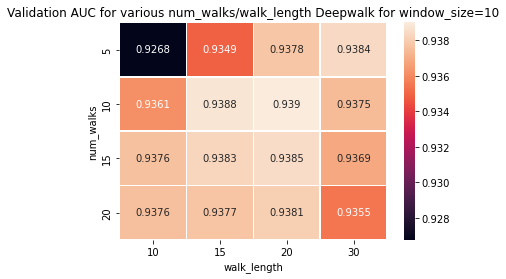

In [ ]:
deepwalk_auc_as_np = np.array([[deepwalk_auc_scores[(node_dim, num_walks, walk_length, 10)] for walk_length in walk_length_list] for num_walks in num_walks_list])

ax_deepwalk = sns.heatmap(deepwalk_auc_as_np, annot=True, fmt='.4g', linewidth=0.5, 
                            xticklabels=walk_length_list, yticklabels=num_walks_list)
ax_deepwalk.set_xlabel('walk_length', fontsize=10)
ax_deepwalk.set_ylabel('num_walks', fontsize=10)
ax_deepwalk.set_title("Validation AUC for various num_walks/walk_length Deepwalk for window_size=10")
plt.show()

In [ ]:
np.random.seed(0)

node_dim = 10
# choose num_walks, walk_length and windowsize hyperparameter according to hyperparameter tuning result for DeepWalk
num_walks = 10
walk_length = 20
windowsize = 10
p_list = [0.3, 0.6, 0.9, 1.2, 1.6, 2]
q_list = [0.3, 0.6, 0.9, 1.2, 1.6, 2]
node2vec_auc_scores = dict()

for p in p_list:
    for q in q_list:
        print("node dim: %d,\tnum_walks: %d,\twalk_length: %d,\tp: %.2f,\tq: %.2f" % (node_dim, num_walks, walk_length, p, q), end="\t")
        alias_nodes, alias_edges = preprocess_transition_probs(graph, p=p, q=q)
        model = build_node2vec(graph, alias_nodes, alias_edges, 
                              node_dim=node_dim, num_walks=num_walks, walk_length=walk_length, window_size=windowsize)
        node2vec_auc_scores[(node_dim, num_walks, walk_length, p, q)] = get_auc_score(model, valid_edges, false_edges)
        print("auc: %.4f" % (node2vec_auc_scores[(node_dim, num_walks, walk_length, p, q)]))

node dim: 10,	num_walks: 10,	walk_length: 20,	p: 0.30,	q: 0.30	building a node2vec model...	number of walks: 83430	average walk length: 19.9749	training time: 123.9526
auc: 0.9377
node dim: 10,	num_walks: 10,	walk_length: 20,	p: 0.30,	q: 0.60	building a node2vec model...	number of walks: 83430	average walk length: 19.9804	training time: 124.3076
auc: 0.9361
node dim: 10,	num_walks: 10,	walk_length: 20,	p: 0.30,	q: 0.90	building a node2vec model...	number of walks: 83430	average walk length: 19.9825	training time: 123.4955
auc: 0.9367
node dim: 10,	num_walks: 10,	walk_length: 20,	p: 0.30,	q: 1.20	building a node2vec model...	number of walks: 83430	average walk length: 19.9835	training time: 122.7678
auc: 0.9362
node dim: 10,	num_walks: 10,	walk_length: 20,	p: 0.30,	q: 1.60	building a node2vec model...	number of walks: 83430	average walk length: 19.9840	training time: 122.7858
auc: 0.9360
node dim: 10,	num_walks: 10,	walk_length: 20,	p: 0.30,	q: 2.00	building a node2vec model...	number o

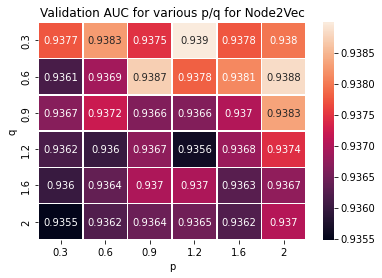

In [ ]:
node2vec_auc_as_np = np.array([[node2vec_auc_scores[(node_dim, num_walks, walk_length, p_val, q_val)] for p_val in p_list] for q_val in q_list])

ax_node2vec = sns.heatmap(node2vec_auc_as_np, annot=True, fmt='.4g', linewidth=0.5, 
                            xticklabels=p_list, yticklabels=q_list)
ax_node2vec.set_xlabel('p', fontsize=10)
ax_node2vec.set_ylabel('q', fontsize=10)
ax_node2vec.set_title("Validation AUC for various p/q for Node2Vec")
plt.show()

In [ ]:
# given a set of true and false edges, gets a given model to output prediction for each edge in form of probability 
# as to whether that link exists or not
def get_pred_score(model, true_edges, false_edges):
   
    y_score = list()
    for e in true_edges:
        y_score.append(get_cosine_sim(model, e[0], e[1]))
    for e in false_edges:
        y_score.append(get_cosine_sim(model, e[0], e[1]))
    
    return y_score

You can build model with the best parameters you find and save the prediction here.

In [ ]:
final_node_dim = 10
final_num_walks = 10
final_walk_length = 20
final_p = 1.0
final_q = 1.0
final_wsize = 10

# build an ensemble model, use multiple DeepWalks and Node2Vecs to reduce variance of predictions
pred_scores = []
alias_nodes, alias_edges = preprocess_transition_probs(graph, p=final_p, q=final_q) # final_p and final_q are unused since DeepWalk is just 1st order random walk
dw1_model = build_deepwalk(graph, alias_nodes, 
                           node_dim=final_node_dim, num_walks=final_num_walks, walk_length=final_walk_length, window_size=final_wsize)
dw1_auc = get_auc_score(dw1_model, valid_edges, false_edges)
print("DeepWalk 1 auc score: %.4f" %(dw1_auc))
dw1_pred = get_pred_score(dw1_model, valid_edges, false_edges) 
pred_scores.append(dw1_pred)

dw2_model = build_deepwalk(graph, alias_nodes, 
                           node_dim=final_node_dim, num_walks=final_num_walks, walk_length=final_walk_length, window_size=final_wsize)
dw2_auc = get_auc_score(dw2_model, valid_edges, false_edges)
print("DeepWalk 2 auc score: %.4f" %(dw2_auc))
dw2_pred = get_pred_score(dw2_model, valid_edges, false_edges) 
pred_scores.append(dw2_pred)

building a DeepWalk model...	number of walks: 83430	average walk length: 19.7383	training time: 126.7766
DeepWalk 1 auc score: 0.9395
building a DeepWalk model...	number of walks: 83430	average walk length: 19.7383	training time: 123.4926
DeepWalk 2 auc score: 0.9396


In [ ]:
final_node_dim = 10
final_num_walks = 10
final_walk_length = 20
final_p = 1.2
final_q = 0.3
final_wsize = 10

alias_nodes, alias_edges = preprocess_transition_probs(graph, p=final_p, q=final_q)
nv1_model = build_node2vec(graph, alias_nodes, alias_edges, 
                           node_dim=final_node_dim, num_walks=final_num_walks, walk_length=final_walk_length, window_size=final_wsize)
nv1_auc = get_auc_score(nv1_model, valid_edges, false_edges)
print("Node2Vec 1 auc score: %.4f" %(nv1_auc))
nv1_pred = get_pred_score(nv1_model, valid_edges, false_edges) 
pred_scores.append(nv1_pred)

nv2_model = build_node2vec(graph, alias_nodes, alias_edges, 
                           node_dim=final_node_dim, num_walks=final_num_walks, walk_length=final_walk_length, window_size=final_wsize)
nv2_auc = get_auc_score(nv2_model, valid_edges, false_edges)
print("Node2Vec 2 auc score: %.4f" %(nv2_auc))
nv2_pred = get_pred_score(nv2_model, valid_edges, false_edges) 
pred_scores.append(nv2_pred)

building a node2vec model...	number of walks: 83430	average walk length: 19.9527	training time: 128.1077
Node2Vec 1 auc score: 0.9385
building a node2vec model...	number of walks: 83430	average walk length: 19.9527	training time: 127.4006
Node2Vec 2 auc score: 0.9387


In [ ]:
test_scores = []
test1_scores = [get_cosine_sim(dw1_model, src, dst) for src, dst in test_edges]
test2_scores = [get_cosine_sim(dw2_model, src, dst) for src, dst in test_edges]

test3_scores = [get_cosine_sim(nv1_model, src, dst) for src, dst in test_edges]
test4_scores = [get_cosine_sim(nv2_model, src, dst) for src, dst in test_edges]

test_scores.append(test1_scores)
test_scores.append(test2_scores)
test_scores.append(test3_scores)
test_scores.append(test4_scores)

scores = np.array(test_scores)
scores = list(np.mean(scores, axis = 0))

write_pred("./pred.csv", test_edges, scores)

And you can have a try if you set p=q=1, the two models will return the same results.